In [1]:
import torch
import torch.nn as nn
import torch.nn.utils.rnn as rnn
import torch.nn.functional as F
import torch.optim as optim

import numpy as np
import matplotlib.pyplot as plt
import sys

from Bio import SeqIO
from datetime import datetime

from torch.utils import data
#from data_generator import data_generator
from data_generator import Dataset
from lstm import LSTM_model
from lstm import LSTMCell
from alpha_set import alpha_set
from print_seq import print_seq

In [2]:
#acids = "abcdefghijklmnopqrstuvwxyz-"
acids = "ACDEFGHIKLMNOPQRSTUVWY-"
large_file = "uniref50.fasta"
small_file = "100k_rows.fasta"
test_file = "test.fasta"

#max_seq_len = 50
#max_seq_len = 2000
max_seq_len = 500

# Good sizes: 16/700 or 32/400 on laptop
# 32/1500 on desktop
batch_size = 32
hidden_dim = 400

hidden_layers = 1

# Use Cuda if available
use_cuda = torch.cuda.is_available() and True
print("Using GPU:", use_cuda)
processor = torch.device("cuda:0" if use_cuda else "cpu")
torch.backends.cudnn.benchmark = True


# Initialising data generator
dataset = Dataset(small_file, max_seq_len, acids=acids)
#dataset = alpha_set(acids, max_seq_len, 3200)
base_generator = data.DataLoader(dataset, batch_size=batch_size, shuffle=True)

# Initialising for training
model = LSTM_model(len(acids), hidden_dim, hidden_layers, max_seq_len, batch_size, processor).to(processor)
loss_function = nn.CrossEntropyLoss(reduction="mean").to(processor)
optimiser = optim.SGD(model.parameters(), lr=5e-2, momentum=0.9, nesterov=True)

# Best lr so far is 2e-2
#optimiser = optim.Adam(model.parameters(), lr=5e-4, weight_decay=0.001)

Using GPU: True


In [3]:
# Initialising some variables for use in training
batches = 1000
time_diff = 0
no_improv = 0
min_loss = float("inf")
loss_list = []
epochs = 1
print_stuff = True

# Main training loop
for epoch in range(epochs):
    for i, (batch, labels, valid_elems) in enumerate(base_generator):

        # Keeping track of stuff
        start_time = datetime.now()
        sys.stdout.write("\rBatch: {0}. Min loss: {1:.5f}. Estimated time left: {2}. Batches since improvement: {3}.".format(i+1, min_loss, time_diff*(batches - i), no_improv))

        # Putting data on gpu
        batch = batch.to(processor)
        labels = labels.to(processor)
        valid_elems = valid_elems.to(processor)

        # Transposing from (batch x seq x feature_size) to (seq x batch x feature_size)
        batch = batch.transpose(0, 1)

        # Resetting gradients
        model.train()
        model.zero_grad()
    
        if i == 0 and print_stuff:
            print("\nInput:\t", batch.size())
            print("Labels:\t", labels.size())
            print("Valid:\t", valid_elems)

        batch = rnn.pack_padded_sequence(batch, valid_elems, enforce_sorted=False)
        labels = rnn.pack_padded_sequence(labels, valid_elems, enforce_sorted=False, batch_first=True)

        out, hidden = model(batch)
        
        out = rnn.pack_padded_sequence(out, valid_elems, enforce_sorted=False)
        if i == 0 and print_stuff:
            print("Output:\t", out.data.size())
            print("Hidden:\t", hidden.data.size())


        #print(out.data.size())
        #print(labels.data.size())
        loss = loss_function(out.data, labels.data)
    
        '''
        # This bit is replaced by packing labels and the line above
        # Backpropping only through the non-padded parts
        loss = 0
        for j in range(out.size()[1]):
        #print(out.size())
        #print(torch.narrow(out, 1, j, 1).squeeze(1).size())
        
        narrowed_out = torch.narrow(torch.narrow(out, 1, j, 1).squeeze(1), 0, 0, valid_elems[j])
        narrowed_labels = torch.narrow(labels[j], 0, 0, valid_elems[j])

        #print_seq(narrowed_out[0].view(1,2000,23))
        
        print(narrowed_out.size())
        print(narrowed_labels.size())
        loss += loss_function(narrowed_out, narrowed_labels)
        '''
        #loss /= out.size()[1]

        loss_list.append(loss.item())
        loss.backward()
        optimiser.step()

        if loss.item() < min_loss:
            torch.save(model.state_dict(), "model.pth")
            min_loss = loss.item()
            no_improv = 0
        else:
            no_improv += 1
        
    
    
        # For tracking progress
        end_time = datetime.now()
        time_diff = end_time - start_time
    
        # Breaking when it's run through the given number of batches
        if i+1 >= batches:
            break

Batch: 1. Min loss: inf. Estimated time left: 0. Batches since improvement: 0.
Input:	 torch.Size([500, 32, 23])
Labels:	 torch.Size([32, 500])
Valid:	 tensor([285, 219, 206, 471, 480,  89, 194,  13, 430, 148, 397, 402, 392, 104,
        411, 303, 332, 100, 102, 233, 473,  94, 160, 288, 267, 181, 256, 409,
        367, 290, 404, 440], device='cuda:0')
Output:	 torch.Size([8940, 23])
Hidden:	 torch.Size([8940, 400])


Batch: 2. Min loss: 3.13203. Estimated time left: 0:03:59.415345. Batches since improvement: 0.

Batch: 3. Min loss: 3.13084. Estimated time left: 0:03:45.905284. Batches since improvement: 0.

Batch: 4. Min loss: 3.12750. Estimated time left: 0:03:55.797479. Batches since improvement: 0.

Batch: 5. Min loss: 3.12444. Estimated time left: 0:03:55.998216. Batches since improvement: 0.

Batch: 6. Min loss: 3.11814. Estimated time left: 0:03:40.985520. Batches since improvement: 0.

Batch: 7. Min loss: 3.11264. Estimated time left: 0:03:59.095766. Batches since improvement: 0.

Batch: 8. Min loss: 3.10793. Estimated time left: 0:03:28.571706. Batches since improvement: 0.

Batch: 9. Min loss: 3.10109. Estimated time left: 0:04:06.035840. Batches since improvement: 0.

Batch: 10. Min loss: 3.09331. Estimated time left: 0:03:48.514690. Batches since improvement: 0.

Batch: 11. Min loss: 3.08956. Estimated time left: 0:03:57.726720. Batches since improvement: 0.

Batch: 12. Min loss: 3.07910. Estimated time left: 0:03:49.651734. Batches since improvement: 0.

Batch: 13. Min loss: 3.07339. Estimated time left: 0:04:00.546384. Batches since improvement: 0.

Batch: 14. Min loss: 3.06606. Estimated time left: 0:03:47.123505. Batches since improvement: 0.

Batch: 15. Min loss: 3.06040. Estimated time left: 0:03:55.707244. Batches since improvement: 0.

Batch: 16. Min loss: 3.05312. Estimated time left: 0:03:49.272540. Batches since improvement: 0.

Batch: 17. Min loss: 3.04662. Estimated time left: 0:03:42.463704. Batches since improvement: 0.

Batch: 18. Min loss: 3.03750. Estimated time left: 0:03:45.609313. Batches since improvement: 0.

Batch: 19. Min loss: 3.03024. Estimated time left: 0:03:57.433852. Batches since improvement: 0.

Batch: 20. Min loss: 3.02623. Estimated time left: 0:03:24.424704. Batches since improvement: 0.

Batch: 21. Min loss: 3.01768. Estimated time left: 0:03:47.073840. Batches since improvement: 0.

Batch: 22. Min loss: 3.01029. Estimated time left: 0:03:47.579319. Batches since improvement: 0.

Batch: 23. Min loss: 3.00135. Estimated time left: 0:03:48.244662. Batches since improvement: 0.

Batch: 24. Min loss: 2.99563. Estimated time left: 0:04:02.506055. Batches since improvement: 0.

Batch: 25. Min loss: 2.99364. Estimated time left: 0:03:50.851328. Batches since improvement: 0.

Batch: 26. Min loss: 2.98894. Estimated time left: 0:03:57.210675. Batches since improvement: 0.

Batch: 27. Min loss: 2.97919. Estimated time left: 0:03:33.601122. Batches since improvement: 0.

Batch: 28. Min loss: 2.97919. Estimated time left: 0:03:50.745004. Batches since improvement: 1.

Batch: 29. Min loss: 2.96155. Estimated time left: 0:03:37.589976. Batches since improvement: 0.

Batch: 30. Min loss: 2.95330. Estimated time left: 0:03:44.660270. Batches since improvement: 0.

Batch: 31. Min loss: 2.95330. Estimated time left: 0:03:30.879940. Batches since improvement: 1.

Batch: 32. Min loss: 2.95330. Estimated time left: 0:03:47.015382. Batches since improvement: 2.

Batch: 33. Min loss: 2.94676. Estimated time left: 0:03:41.663288. Batches since improvement: 0.

Batch: 34. Min loss: 2.93018. Estimated time left: 0:03:56.154938. Batches since improvement: 0.

Batch: 35. Min loss: 2.93018. Estimated time left: 0:03:35.390952. Batches since improvement: 1.

Batch: 36. Min loss: 2.92227. Estimated time left: 0:03:53.109260. Batches since improvement: 0.

Batch: 37. Min loss: 2.92096. Estimated time left: 0:03:43.703912. Batches since improvement: 0.

Batch: 38. Min loss: 2.92096. Estimated time left: 0:03:25.466643. Batches since improvement: 1.

Batch: 39. Min loss: 2.91211. Estimated time left: 0:03:40.847302. Batches since improvement: 0.

Batch: 40. Min loss: 2.91211. Estimated time left: 0:03:24.945743. Batches since improvement: 1.

Batch: 41. Min loss: 2.91211. Estimated time left: 0:03:57.522240. Batches since improvement: 2.

Batch: 42. Min loss: 2.89586. Estimated time left: 0:03:38.632820. Batches since improvement: 0.

Batch: 43. Min loss: 2.89586. Estimated time left: 0:03:56.035872. Batches since improvement: 1.

Batch: 44. Min loss: 2.89586. Estimated time left: 0:03:45.567771. Batches since improvement: 2.

Batch: 45. Min loss: 2.89586. Estimated time left: 0:03:27.574368. Batches since improvement: 3.

Batch: 46. Min loss: 2.88932. Estimated time left: 0:03:33.003200. Batches since improvement: 0.

Batch: 47. Min loss: 2.86812. Estimated time left: 0:03:43.985844. Batches since improvement: 0.

Batch: 48. Min loss: 2.86812. Estimated time left: 0:03:43.539492. Batches since improvement: 1.

Batch: 49. Min loss: 2.86812. Estimated time left: 0:03:41.384744. Batches since improvement: 2.

Batch: 50. Min loss: 2.86812. Estimated time left: 0:03:43.289094. Batches since improvement: 3.

Batch: 51. Min loss: 2.86812. Estimated time left: 0:03:31.179300. Batches since improvement: 4.

Batch: 52. Min loss: 2.86812. Estimated time left: 0:03:38.982699. Batches since improvement: 5.

Batch: 53. Min loss: 2.86812. Estimated time left: 0:03:27.814872. Batches since improvement: 6.

Batch: 54. Min loss: 2.86812. Estimated time left: 0:03:40.277882. Batches since improvement: 7.

Batch: 55. Min loss: 2.85906. Estimated time left: 0:03:50.329242. Batches since improvement: 0.

Batch: 56. Min loss: 2.85906. Estimated time left: 0:03:12.869775. Batches since improvement: 1.

Batch: 57. Min loss: 2.85906. Estimated time left: 0:03:40.011472. Batches since improvement: 2.

Batch: 58. Min loss: 2.85906. Estimated time left: 0:03:39.214495. Batches since improvement: 3.

Batch: 59. Min loss: 2.85066. Estimated time left: 0:03:53.715852. Batches since improvement: 0.

Batch: 60. Min loss: 2.84715. Estimated time left: 0:03:27.978879. Batches since improvement: 0.

Batch: 61. Min loss: 2.84715. Estimated time left: 0:03:32.111940. Batches since improvement: 1.

Batch: 62. Min loss: 2.84715. Estimated time left: 0:03:44.623824. Batches since improvement: 2.

Batch: 63. Min loss: 2.84715. Estimated time left: 0:03:47.073854. Batches since improvement: 3.

Batch: 64. Min loss: 2.83833. Estimated time left: 0:03:40.090056. Batches since improvement: 0.

Batch: 65. Min loss: 2.83833. Estimated time left: 0:03:20.503368. Batches since improvement: 1.

Batch: 66. Min loss: 2.83024. Estimated time left: 0:03:27.114655. Batches since improvement: 0.

Batch: 67. Min loss: 2.83024. Estimated time left: 0:03:39.419016. Batches since improvement: 1.

Batch: 68. Min loss: 2.83024. Estimated time left: 0:03:28.291317. Batches since improvement: 2.

Batch: 69. Min loss: 2.83024. Estimated time left: 0:03:26.309384. Batches since improvement: 3.

Batch: 70. Min loss: 2.82810. Estimated time left: 0:03:44.627956. Batches since improvement: 0.

Batch: 71. Min loss: 2.82810. Estimated time left: 0:03:39.676230. Batches since improvement: 1.

Batch: 72. Min loss: 2.82810. Estimated time left: 0:03:27.559038. Batches since improvement: 2.

Batch: 73. Min loss: 2.82810. Estimated time left: 0:03:16.826016. Batches since improvement: 3.

Batch: 74. Min loss: 2.82716. Estimated time left: 0:03:20.136519. Batches since improvement: 0.

Batch: 75. Min loss: 2.82542. Estimated time left: 0:03:40.413928. Batches since improvement: 0.

Batch: 76. Min loss: 2.81447. Estimated time left: 0:03:40.062125. Batches since improvement: 0.

Batch: 77. Min loss: 2.81170. Estimated time left: 0:03:34.045524. Batches since improvement: 0.

Batch: 78. Min loss: 2.80977. Estimated time left: 0:03:12.472267. Batches since improvement: 0.

Batch: 79. Min loss: 2.80847. Estimated time left: 0:03:43.324074. Batches since improvement: 0.

Batch: 80. Min loss: 2.79594. Estimated time left: 0:03:41.341167. Batches since improvement: 0.

Batch: 81. Min loss: 2.79594. Estimated time left: 0:03:27.971520. Batches since improvement: 1.

Batch: 82. Min loss: 2.79594. Estimated time left: 0:03:39.615268. Batches since improvement: 2.

Batch: 83. Min loss: 2.79078. Estimated time left: 0:03:44.513424. Batches since improvement: 0.

Batch: 84. Min loss: 2.79078. Estimated time left: 0:03:49.026252. Batches since improvement: 1.

Batch: 85. Min loss: 2.79078. Estimated time left: 0:03:20.272408. Batches since improvement: 2.

Batch: 86. Min loss: 2.79078. Estimated time left: 0:03:37.170675. Batches since improvement: 3.

Batch: 87. Min loss: 2.76515. Estimated time left: 0:03:32.668606. Batches since improvement: 0.

Batch: 88. Min loss: 2.76515. Estimated time left: 0:03:32.740869. Batches since improvement: 1.

Batch: 89. Min loss: 2.76515. Estimated time left: 0:03:35.156304. Batches since improvement: 2.

Batch: 90. Min loss: 2.76515. Estimated time left: 0:03:35.580862. Batches since improvement: 3.

Batch: 91. Min loss: 2.76515. Estimated time left: 0:03:30.189980. Batches since improvement: 4.

Batch: 92. Min loss: 2.76515. Estimated time left: 0:03:37.425528. Batches since improvement: 5.

Batch: 93. Min loss: 2.76515. Estimated time left: 0:03:29.352112. Batches since improvement: 6.

Batch: 94. Min loss: 2.76515. Estimated time left: 0:03:24.726226. Batches since improvement: 7.

Batch: 95. Min loss: 2.76515. Estimated time left: 0:03:29.372070. Batches since improvement: 8.

Batch: 96. Min loss: 2.76515. Estimated time left: 0:03:11.217450. Batches since improvement: 9.

Batch: 97. Min loss: 2.76515. Estimated time left: 0:03:22.066600. Batches since improvement: 10.

Batch: 98. Min loss: 2.76515. Estimated time left: 0:03:25.382835. Batches since improvement: 11.

Batch: 99. Min loss: 2.75505. Estimated time left: 0:03:20.061796. Batches since improvement: 0.

Batch: 100. Min loss: 2.75505. Estimated time left: 0:03:15.992728. Batches since improvement: 1.

Batch: 101. Min loss: 2.75344. Estimated time left: 0:03:08.747100. Batches since improvement: 0.

Batch: 102. Min loss: 2.74766. Estimated time left: 0:03:29.927288. Batches since improvement: 0.

Batch: 103. Min loss: 2.74766. Estimated time left: 0:03:18.917776. Batches since improvement: 1.

Batch: 104. Min loss: 2.74766. Estimated time left: 0:03:18.123081. Batches since improvement: 2.

Batch: 105. Min loss: 2.74759. Estimated time left: 0:03:29.670272. Batches since improvement: 0.

Batch: 106. Min loss: 2.74720. Estimated time left: 0:03:48.044210. Batches since improvement: 0.

Batch: 107. Min loss: 2.73266. Estimated time left: 0:03:34.214022. Batches since improvement: 0.

Batch: 108. Min loss: 2.73266. Estimated time left: 0:03:07.177265. Batches since improvement: 1.

Batch: 109. Min loss: 2.73266. Estimated time left: 0:03:11.448176. Batches since improvement: 2.

Batch: 110. Min loss: 2.73266. Estimated time left: 0:03:22.995639. Batches since improvement: 3.

Batch: 111. Min loss: 2.72442. Estimated time left: 0:03:34.895840. Batches since improvement: 0.

Batch: 112. Min loss: 2.72442. Estimated time left: 0:03:22.860021. Batches since improvement: 1.

Batch: 113. Min loss: 2.71197. Estimated time left: 0:03:21.799776. Batches since improvement: 0.

Batch: 114. Min loss: 2.71197. Estimated time left: 0:03:38.494710. Batches since improvement: 1.

Batch: 115. Min loss: 2.71019. Estimated time left: 0:03:33.845846. Batches since improvement: 0.

Batch: 116. Min loss: 2.71019. Estimated time left: 0:03:21.426000. Batches since improvement: 1.

Batch: 117. Min loss: 2.70156. Estimated time left: 0:03:34.687356. Batches since improvement: 0.

Batch: 118. Min loss: 2.70156. Estimated time left: 0:03:19.529744. Batches since improvement: 1.

Batch: 119. Min loss: 2.69832. Estimated time left: 0:03:31.874040. Batches since improvement: 0.

Batch: 120. Min loss: 2.69832. Estimated time left: 0:03:23.182387. Batches since improvement: 1.

Batch: 121. Min loss: 2.69782. Estimated time left: 0:03:34.210480. Batches since improvement: 0.

Batch: 122. Min loss: 2.69607. Estimated time left: 0:03:29.246829. Batches since improvement: 0.

Batch: 123. Min loss: 2.69607. Estimated time left: 0:03:19.770462. Batches since improvement: 1.

Batch: 124. Min loss: 2.68829. Estimated time left: 0:03:14.507199. Batches since improvement: 0.

Batch: 125. Min loss: 2.68441. Estimated time left: 0:03:15.549480. Batches since improvement: 0.

Batch: 126. Min loss: 2.68441. Estimated time left: 0:03:26.026625. Batches since improvement: 1.

Batch: 127. Min loss: 2.67375. Estimated time left: 0:03:30.011712. Batches since improvement: 0.

Batch: 128. Min loss: 2.67375. Estimated time left: 0:03:08.702442. Batches since improvement: 1.

Batch: 129. Min loss: 2.67375. Estimated time left: 0:03:16.759824. Batches since improvement: 2.

Batch: 130. Min loss: 2.67375. Estimated time left: 0:03:18.109821. Batches since improvement: 3.

Batch: 131. Min loss: 2.65896. Estimated time left: 0:03:31.809330. Batches since improvement: 0.

Batch: 132. Min loss: 2.64403. Estimated time left: 0:03:11.823060. Batches since improvement: 0.

Batch: 133. Min loss: 2.64403. Estimated time left: 0:03:24.798524. Batches since improvement: 1.

Batch: 134. Min loss: 2.64403. Estimated time left: 0:03:22.512126. Batches since improvement: 2.

Batch: 135. Min loss: 2.64403. Estimated time left: 0:03:18.473344. Batches since improvement: 3.

Batch: 136. Min loss: 2.64143. Estimated time left: 0:03:24.024090. Batches since improvement: 0.

Batch: 137. Min loss: 2.63969. Estimated time left: 0:03:16.325856. Batches since improvement: 0.

Batch: 138. Min loss: 2.62358. Estimated time left: 0:03:17.016859. Batches since improvement: 0.

Batch: 139. Min loss: 2.62070. Estimated time left: 0:03:20.308974. Batches since improvement: 0.

Batch: 140. Min loss: 2.62070. Estimated time left: 0:03:21.199341. Batches since improvement: 1.

Batch: 141. Min loss: 2.62070. Estimated time left: 0:03:21.334600. Batches since improvement: 2.

Batch: 142. Min loss: 2.61431. Estimated time left: 0:03:15.189711. Batches since improvement: 0.

Batch: 143. Min loss: 2.60979. Estimated time left: 0:03:18.778866. Batches since improvement: 0.

Batch: 144. Min loss: 2.60495. Estimated time left: 0:03:11.173561. Batches since improvement: 0.

Batch: 145. Min loss: 2.60495. Estimated time left: 0:03:18.621960. Batches since improvement: 1.

Batch: 146. Min loss: 2.58065. Estimated time left: 0:03:21.826170. Batches since improvement: 0.

Batch: 147. Min loss: 2.58065. Estimated time left: 0:03:22.863430. Batches since improvement: 1.

Batch: 148. Min loss: 2.57269. Estimated time left: 0:03:22.241182. Batches since improvement: 0.

Batch: 149. Min loss: 2.57269. Estimated time left: 0:02:58.932780. Batches since improvement: 1.

Batch: 150. Min loss: 2.57256. Estimated time left: 0:03:29.583429. Batches since improvement: 0.

Batch: 151. Min loss: 2.57256. Estimated time left: 0:03:16.074600. Batches since improvement: 1.

Batch: 152. Min loss: 2.56543. Estimated time left: 0:03:20.233254. Batches since improvement: 0.

Batch: 153. Min loss: 2.56543. Estimated time left: 0:03:13.051440. Batches since improvement: 1.

Batch: 154. Min loss: 2.53966. Estimated time left: 0:03:04.788296. Batches since improvement: 0.

Batch: 155. Min loss: 2.53966. Estimated time left: 0:03:18.262638. Batches since improvement: 1.

Batch: 156. Min loss: 2.53966. Estimated time left: 0:03:21.256185. Batches since improvement: 2.

Batch: 157. Min loss: 2.52856. Estimated time left: 0:03:17.353364. Batches since improvement: 0.

Batch: 158. Min loss: 2.51101. Estimated time left: 0:03:25.675140. Batches since improvement: 0.

Batch: 159. Min loss: 2.51101. Estimated time left: 0:03:20.230126. Batches since improvement: 1.

Batch: 160. Min loss: 2.51101. Estimated time left: 0:03:15.377756. Batches since improvement: 2.

Batch: 161. Min loss: 2.51101. Estimated time left: 0:03:12.355800. Batches since improvement: 3.

Batch: 162. Min loss: 2.50370. Estimated time left: 0:03:22.667162. Batches since improvement: 0.

Batch: 163. Min loss: 2.50370. Estimated time left: 0:02:53.466000. Batches since improvement: 1.

Batch: 164. Min loss: 2.48953. Estimated time left: 0:03:11.390931. Batches since improvement: 0.

Batch: 165. Min loss: 2.46875. Estimated time left: 0:03:12.981404. Batches since improvement: 0.

Batch: 166. Min loss: 2.45448. Estimated time left: 0:02:59.140900. Batches since improvement: 0.

Batch: 167. Min loss: 2.45448. Estimated time left: 0:03:09.805056. Batches since improvement: 1.

Batch: 168. Min loss: 2.45448. Estimated time left: 0:03:12.740373. Batches since improvement: 2.

Batch: 169. Min loss: 2.44872. Estimated time left: 0:03:13.132992. Batches since improvement: 0.

Batch: 170. Min loss: 2.42715. Estimated time left: 0:03:12.916650. Batches since improvement: 0.

Batch: 171. Min loss: 2.41940. Estimated time left: 0:02:47.498150. Batches since improvement: 0.

Batch: 172. Min loss: 2.41940. Estimated time left: 0:03:10.068975. Batches since improvement: 1.

Batch: 173. Min loss: 2.41940. Estimated time left: 0:03:20.453832. Batches since improvement: 2.

Batch: 174. Min loss: 2.41167. Estimated time left: 0:03:20.263012. Batches since improvement: 0.

Batch: 175. Min loss: 2.38915. Estimated time left: 0:03:07.936476. Batches since improvement: 0.

Batch: 176. Min loss: 2.38915. Estimated time left: 0:02:51.442425. Batches since improvement: 1.

Batch: 177. Min loss: 2.38915. Estimated time left: 0:03:20.393504. Batches since improvement: 2.

Batch: 178. Min loss: 2.38915. Estimated time left: 0:03:09.536077. Batches since improvement: 3.

Batch: 179. Min loss: 2.35914. Estimated time left: 0:03:24.903228. Batches since improvement: 0.

Batch: 180. Min loss: 2.35914. Estimated time left: 0:03:12.643545. Batches since improvement: 1.

Batch: 181. Min loss: 2.35914. Estimated time left: 0:03:11.627440. Batches since improvement: 2.

Batch: 182. Min loss: 2.35085. Estimated time left: 0:02:48.066171. Batches since improvement: 0.

Batch: 183. Min loss: 2.34243. Estimated time left: 0:03:22.448456. Batches since improvement: 0.

Batch: 184. Min loss: 2.32704. Estimated time left: 0:03:16.351244. Batches since improvement: 0.

Batch: 185. Min loss: 2.32445. Estimated time left: 0:03:07.125936. Batches since improvement: 0.

Batch: 186. Min loss: 2.30641. Estimated time left: 0:03:00.436110. Batches since improvement: 0.

Batch: 187. Min loss: 2.29950. Estimated time left: 0:03:04.662412. Batches since improvement: 0.

Batch: 188. Min loss: 2.28342. Estimated time left: 0:03:08.740389. Batches since improvement: 0.

Batch: 189. Min loss: 2.28342. Estimated time left: 0:03:12.980732. Batches since improvement: 1.

Batch: 190. Min loss: 2.27753. Estimated time left: 0:03:20.452437. Batches since improvement: 0.

Batch: 191. Min loss: 2.26708. Estimated time left: 0:03:02.757870. Batches since improvement: 0.

Batch: 192. Min loss: 2.26708. Estimated time left: 0:03:13.545160. Batches since improvement: 1.

Batch: 193. Min loss: 2.23156. Estimated time left: 0:03:12.170680. Batches since improvement: 0.

Batch: 194. Min loss: 2.20667. Estimated time left: 0:02:56.720088. Batches since improvement: 0.

Batch: 195. Min loss: 2.20667. Estimated time left: 0:03:00.325574. Batches since improvement: 1.

Batch: 196. Min loss: 2.20667. Estimated time left: 0:03:05.713500. Batches since improvement: 2.

Batch: 197. Min loss: 2.18417. Estimated time left: 0:03:04.640208. Batches since improvement: 0.

Batch: 198. Min loss: 2.17023. Estimated time left: 0:02:54.431675. Batches since improvement: 0.

Batch: 199. Min loss: 2.17023. Estimated time left: 0:03:00.993756. Batches since improvement: 1.

Batch: 200. Min loss: 2.15193. Estimated time left: 0:03:09.726462. Batches since improvement: 0.

Batch: 201. Min loss: 2.15193. Estimated time left: 0:03:07.539200. Batches since improvement: 1.

Batch: 202. Min loss: 2.12292. Estimated time left: 0:03:04.518663. Batches since improvement: 0.

Batch: 203. Min loss: 2.12199. Estimated time left: 0:03:07.374390. Batches since improvement: 0.

Batch: 204. Min loss: 2.11033. Estimated time left: 0:02:44.291986. Batches since improvement: 0.

Batch: 205. Min loss: 2.10984. Estimated time left: 0:03:02.718616. Batches since improvement: 0.

Batch: 206. Min loss: 2.08827. Estimated time left: 0:02:51.831300. Batches since improvement: 0.

Batch: 207. Min loss: 2.08827. Estimated time left: 0:03:13.054748. Batches since improvement: 1.

Batch: 208. Min loss: 2.06947. Estimated time left: 0:03:10.622926. Batches since improvement: 0.

Batch: 209. Min loss: 2.02899. Estimated time left: 0:02:52.168128. Batches since improvement: 0.

Batch: 210. Min loss: 2.00170. Estimated time left: 0:03:04.337013. Batches since improvement: 0.

Batch: 211. Min loss: 2.00170. Estimated time left: 0:02:44.037180. Batches since improvement: 1.

Batch: 212. Min loss: 2.00170. Estimated time left: 0:03:16.288998. Batches since improvement: 2.

Batch: 213. Min loss: 2.00170. Estimated time left: 0:03:02.111528. Batches since improvement: 3.

Batch: 214. Min loss: 1.99897. Estimated time left: 0:03:08.710795. Batches since improvement: 0.

Batch: 215. Min loss: 1.99897. Estimated time left: 0:02:59.047656. Batches since improvement: 1.

Batch: 216. Min loss: 1.95896. Estimated time left: 0:03:05.963360. Batches since improvement: 0.

Batch: 217. Min loss: 1.95222. Estimated time left: 0:02:59.225536. Batches since improvement: 0.

Batch: 218. Min loss: 1.95114. Estimated time left: 0:02:54.399939. Batches since improvement: 0.

Batch: 219. Min loss: 1.89561. Estimated time left: 0:02:47.412124. Batches since improvement: 0.

Batch: 220. Min loss: 1.88139. Estimated time left: 0:02:58.164063. Batches since improvement: 0.

Batch: 221. Min loss: 1.86664. Estimated time left: 0:02:55.287060. Batches since improvement: 0.

Batch: 222. Min loss: 1.86664. Estimated time left: 0:03:09.977846. Batches since improvement: 1.

Batch: 223. Min loss: 1.82932. Estimated time left: 0:03:14.089216. Batches since improvement: 0.

Batch: 224. Min loss: 1.82932. Estimated time left: 0:02:59.579463. Batches since improvement: 1.

Batch: 225. Min loss: 1.80418. Estimated time left: 0:03:04.144024. Batches since improvement: 0.

Batch: 226. Min loss: 1.80418. Estimated time left: 0:02:51.017700. Batches since improvement: 1.

Batch: 227. Min loss: 1.79302. Estimated time left: 0:03:06.938802. Batches since improvement: 0.

Batch: 228. Min loss: 1.78133. Estimated time left: 0:02:52.654188. Batches since improvement: 0.

Batch: 229. Min loss: 1.72433. Estimated time left: 0:03:12.019560. Batches since improvement: 0.

Batch: 230. Min loss: 1.72433. Estimated time left: 0:02:52.286118. Batches since improvement: 1.

Batch: 231. Min loss: 1.72433. Estimated time left: 0:02:52.267480. Batches since improvement: 2.

Batch: 232. Min loss: 1.66911. Estimated time left: 0:02:50.500373. Batches since improvement: 0.

Batch: 233. Min loss: 1.66635. Estimated time left: 0:02:40.805376. Batches since improvement: 0.

Batch: 234. Min loss: 1.66635. Estimated time left: 0:02:58.178702. Batches since improvement: 1.

Batch: 235. Min loss: 1.64177. Estimated time left: 0:03:03.046424. Batches since improvement: 0.

Batch: 236. Min loss: 1.59668. Estimated time left: 0:02:56.965155. Batches since improvement: 0.

Batch: 237. Min loss: 1.58089. Estimated time left: 0:02:54.821536. Batches since improvement: 0.

Batch: 238. Min loss: 1.51935. Estimated time left: 0:02:39.601288. Batches since improvement: 0.

Batch: 239. Min loss: 1.51935. Estimated time left: 0:02:53.073822. Batches since improvement: 1.

Batch: 240. Min loss: 1.45455. Estimated time left: 0:03:02.985494. Batches since improvement: 0.

Batch: 241. Min loss: 1.45455. Estimated time left: 0:02:52.838440. Batches since improvement: 1.

Batch: 242. Min loss: 1.45227. Estimated time left: 0:02:57.237885. Batches since improvement: 0.

Batch: 243. Min loss: 1.42595. Estimated time left: 0:03:02.517304. Batches since improvement: 0.

Batch: 244. Min loss: 1.36729. Estimated time left: 0:02:51.438547. Batches since improvement: 0.

Batch: 245. Min loss: 1.36729. Estimated time left: 0:02:49.026480. Batches since improvement: 1.

Batch: 246. Min loss: 1.36729. Estimated time left: 0:02:50.147555. Batches since improvement: 2.

Batch: 247. Min loss: 1.30013. Estimated time left: 0:03:04.916992. Batches since improvement: 0.

Batch: 248. Min loss: 1.25230. Estimated time left: 0:02:46.042524. Batches since improvement: 0.

Batch: 249. Min loss: 1.24222. Estimated time left: 0:02:53.548064. Batches since improvement: 0.

Batch: 250. Min loss: 1.23135. Estimated time left: 0:02:57.267542. Batches since improvement: 0.

Batch: 251. Min loss: 1.21801. Estimated time left: 0:03:02.243250. Batches since improvement: 0.

Batch: 252. Min loss: 1.15106. Estimated time left: 0:03:01.804021. Batches since improvement: 0.

Batch: 253. Min loss: 1.15106. Estimated time left: 0:02:51.845520. Batches since improvement: 1.

Batch: 254. Min loss: 1.15106. Estimated time left: 0:02:44.116647. Batches since improvement: 2.

Batch: 255. Min loss: 1.13070. Estimated time left: 0:02:51.682948. Batches since improvement: 0.

Batch: 256. Min loss: 1.07838. Estimated time left: 0:03:01.411225. Batches since improvement: 0.

Batch: 257. Min loss: 1.03717. Estimated time left: 0:02:51.917568. Batches since improvement: 0.

Batch: 258. Min loss: 1.00511. Estimated time left: 0:02:39.461917. Batches since improvement: 0.

Batch: 259. Min loss: 0.97000. Estimated time left: 0:02:49.176742. Batches since improvement: 0.

Batch: 260. Min loss: 0.93524. Estimated time left: 0:02:45.306726. Batches since improvement: 0.

Batch: 261. Min loss: 0.93524. Estimated time left: 0:02:53.714260. Batches since improvement: 1.

Batch: 262. Min loss: 0.93524. Estimated time left: 0:02:56.574443. Batches since improvement: 2.

Batch: 263. Min loss: 0.93524. Estimated time left: 0:02:58.816662. Batches since improvement: 3.

Batch: 264. Min loss: 0.91311. Estimated time left: 0:02:49.397976. Batches since improvement: 0.

Batch: 265. Min loss: 0.80342. Estimated time left: 0:02:56.495744. Batches since improvement: 0.

Batch: 266. Min loss: 0.80342. Estimated time left: 0:02:40.895175. Batches since improvement: 1.

Batch: 267. Min loss: 0.76518. Estimated time left: 0:02:54.125352. Batches since improvement: 0.

Batch: 268. Min loss: 0.76518. Estimated time left: 0:03:16.237294. Batches since improvement: 1.

Batch: 269. Min loss: 0.74300. Estimated time left: 0:02:47.867364. Batches since improvement: 0.

Batch: 270. Min loss: 0.74300. Estimated time left: 0:03:34.922772. Batches since improvement: 1.

Batch: 271. Min loss: 0.73361. Estimated time left: 0:02:45.126730. Batches since improvement: 0.

Batch: 272. Min loss: 0.69676. Estimated time left: 0:02:50.597664. Batches since improvement: 0.

Batch: 273. Min loss: 0.69335. Estimated time left: 0:03:00.220040. Batches since improvement: 0.

Batch: 274. Min loss: 0.62137. Estimated time left: 0:03:26.481813. Batches since improvement: 0.

Batch: 275. Min loss: 0.62137. Estimated time left: 0:02:39.240840. Batches since improvement: 1.

Batch: 276. Min loss: 0.61159. Estimated time left: 0:02:47.380750. Batches since improvement: 0.

Batch: 277. Min loss: 0.59322. Estimated time left: 0:02:51.292608. Batches since improvement: 0.

Batch: 278. Min loss: 0.58758. Estimated time left: 0:02:58.739337. Batches since improvement: 0.

Batch: 279. Min loss: 0.57147. Estimated time left: 0:02:57.513086. Batches since improvement: 0.

Batch: 280. Min loss: 0.56623. Estimated time left: 0:02:49.962051. Batches since improvement: 0.

Batch: 281. Min loss: 0.56623. Estimated time left: 0:02:42.677520. Batches since improvement: 1.

Batch: 282. Min loss: 0.52617. Estimated time left: 0:02:48.878001. Batches since improvement: 0.

Batch: 283. Min loss: 0.51113. Estimated time left: 0:02:51.235820. Batches since improvement: 0.

Batch: 284. Min loss: 0.51113. Estimated time left: 0:02:49.830054. Batches since improvement: 1.

Batch: 285. Min loss: 0.49686. Estimated time left: 0:02:59.105252. Batches since improvement: 0.

Batch: 286. Min loss: 0.49686. Estimated time left: 0:02:36.638625. Batches since improvement: 1.

Batch: 287. Min loss: 0.49686. Estimated time left: 0:02:41.906640. Batches since improvement: 2.

Batch: 288. Min loss: 0.46790. Estimated time left: 0:02:47.003138. Batches since improvement: 0.

Batch: 289. Min loss: 0.46116. Estimated time left: 0:02:57.045920. Batches since improvement: 0.

Batch: 290. Min loss: 0.43635. Estimated time left: 0:02:47.819463. Batches since improvement: 0.

Batch: 291. Min loss: 0.40134. Estimated time left: 0:03:12.750800. Batches since improvement: 0.

Batch: 292. Min loss: 0.40134. Estimated time left: 0:03:46.214958. Batches since improvement: 1.

Batch: 293. Min loss: 0.40134. Estimated time left: 0:03:30.632832. Batches since improvement: 2.

Batch: 294. Min loss: 0.40134. Estimated time left: 0:02:47.813520. Batches since improvement: 3.

Batch: 295. Min loss: 0.40134. Estimated time left: 0:03:24.682814. Batches since improvement: 4.

Batch: 296. Min loss: 0.38266. Estimated time left: 0:03:00.139485. Batches since improvement: 0.

Batch: 297. Min loss: 0.38266. Estimated time left: 0:02:47.475264. Batches since improvement: 1.

Batch: 298. Min loss: 0.36893. Estimated time left: 0:02:54.999196. Batches since improvement: 0.

Batch: 299. Min loss: 0.35553. Estimated time left: 0:02:52.663920. Batches since improvement: 0.

Batch: 300. Min loss: 0.35553. Estimated time left: 0:02:38.913896. Batches since improvement: 1.

Batch: 301. Min loss: 0.34326. Estimated time left: 0:02:43.891700. Batches since improvement: 0.

Batch: 302. Min loss: 0.34326. Estimated time left: 0:02:44.050407. Batches since improvement: 1.

Batch: 303. Min loss: 0.34326. Estimated time left: 0:02:44.526976. Batches since improvement: 2.

Batch: 304. Min loss: 0.33420. Estimated time left: 0:02:39.392748. Batches since improvement: 0.

Batch: 305. Min loss: 0.33420. Estimated time left: 0:02:39.206520. Batches since improvement: 1.

Batch: 306. Min loss: 0.32516. Estimated time left: 0:02:52.569195. Batches since improvement: 0.

Batch: 307. Min loss: 0.30425. Estimated time left: 0:02:25.622020. Batches since improvement: 0.

Batch: 308. Min loss: 0.30218. Estimated time left: 0:02:40.692840. Batches since improvement: 0.

Batch: 309. Min loss: 0.28727. Estimated time left: 0:03:19.320220. Batches since improvement: 0.

Batch: 310. Min loss: 0.28727. Estimated time left: 0:02:33.120072. Batches since improvement: 1.

Batch: 311. Min loss: 0.28727. Estimated time left: 0:02:43.942620. Batches since improvement: 2.

Batch: 312. Min loss: 0.28395. Estimated time left: 0:02:29.220175. Batches since improvement: 0.

Batch: 313. Min loss: 0.28395. Estimated time left: 0:02:29.771408. Batches since improvement: 1.

Batch: 314. Min loss: 0.28395. Estimated time left: 0:02:40.560831. Batches since improvement: 2.

Batch: 315. Min loss: 0.27756. Estimated time left: 0:02:39.251470. Batches since improvement: 0.

Batch: 316. Min loss: 0.25483. Estimated time left: 0:02:42.960815. Batches since improvement: 0.

Batch: 317. Min loss: 0.25483. Estimated time left: 0:02:38.502636. Batches since improvement: 1.

Batch: 318. Min loss: 0.25483. Estimated time left: 0:02:35.153012. Batches since improvement: 2.

Batch: 319. Min loss: 0.24430. Estimated time left: 0:02:42.968674. Batches since improvement: 0.

Batch: 320. Min loss: 0.23464. Estimated time left: 0:02:31.259634. Batches since improvement: 0.

Batch: 321. Min loss: 0.23464. Estimated time left: 0:02:43.100720. Batches since improvement: 1.

Batch: 322. Min loss: 0.23464. Estimated time left: 0:02:17.460834. Batches since improvement: 2.

Batch: 323. Min loss: 0.23464. Estimated time left: 0:02:38.752344. Batches since improvement: 3.

Batch: 324. Min loss: 0.23464. Estimated time left: 0:02:35.658548. Batches since improvement: 4.

Batch: 325. Min loss: 0.23464. Estimated time left: 0:02:41.352412. Batches since improvement: 5.

Batch: 326. Min loss: 0.22823. Estimated time left: 0:02:39.094800. Batches since improvement: 0.

Batch: 327. Min loss: 0.21932. Estimated time left: 0:02:29.160244. Batches since improvement: 0.

Batch: 328. Min loss: 0.21504. Estimated time left: 0:02:35.831131. Batches since improvement: 0.

Batch: 329. Min loss: 0.21504. Estimated time left: 0:02:37.948896. Batches since improvement: 1.

Batch: 330. Min loss: 0.21492. Estimated time left: 0:02:25.508363. Batches since improvement: 0.

Batch: 331. Min loss: 0.21475. Estimated time left: 0:02:36.581010. Batches since improvement: 0.

Batch: 332. Min loss: 0.21475. Estimated time left: 0:02:33.726834. Batches since improvement: 1.

Batch: 333. Min loss: 0.21307. Estimated time left: 0:02:41.702092. Batches since improvement: 0.

Batch: 334. Min loss: 0.20076. Estimated time left: 0:02:33.078501. Batches since improvement: 0.

Batch: 335. Min loss: 0.20076. Estimated time left: 0:02:19.876650. Batches since improvement: 1.

Batch: 336. Min loss: 0.20076. Estimated time left: 0:02:28.376795. Batches since improvement: 2.

Batch: 337. Min loss: 0.20076. Estimated time left: 0:02:31.204088. Batches since improvement: 3.

Batch: 338. Min loss: 0.18938. Estimated time left: 0:02:44.571186. Batches since improvement: 0.

Batch: 339. Min loss: 0.18938. Estimated time left: 0:02:30.847292. Batches since improvement: 1.

Batch: 340. Min loss: 0.17940. Estimated time left: 0:02:29.306019. Batches since improvement: 0.

Batch: 341. Min loss: 0.17810. Estimated time left: 0:02:34.296120. Batches since improvement: 0.

Batch: 342. Min loss: 0.17810. Estimated time left: 0:02:36.078878. Batches since improvement: 1.

Batch: 343. Min loss: 0.17810. Estimated time left: 0:02:31.788098. Batches since improvement: 2.

Batch: 344. Min loss: 0.17810. Estimated time left: 0:02:33.733401. Batches since improvement: 3.

Batch: 345. Min loss: 0.17810. Estimated time left: 0:02:26.767536. Batches since improvement: 4.

Batch: 346. Min loss: 0.16554. Estimated time left: 0:02:44.849090. Batches since improvement: 0.

Batch: 347. Min loss: 0.16554. Estimated time left: 0:02:26.365200. Batches since improvement: 1.

Batch: 348. Min loss: 0.16554. Estimated time left: 0:02:27.969800. Batches since improvement: 2.

Batch: 349. Min loss: 0.16554. Estimated time left: 0:02:26.793236. Batches since improvement: 3.

Batch: 350. Min loss: 0.16089. Estimated time left: 0:02:42.043014. Batches since improvement: 0.

Batch: 351. Min loss: 0.16089. Estimated time left: 0:02:25.467400. Batches since improvement: 1.

Batch: 352. Min loss: 0.16089. Estimated time left: 0:02:25.185194. Batches since improvement: 2.

Batch: 353. Min loss: 0.15209. Estimated time left: 0:02:33.067968. Batches since improvement: 0.

Batch: 354. Min loss: 0.15209. Estimated time left: 0:02:17.776062. Batches since improvement: 1.

Batch: 355. Min loss: 0.15209. Estimated time left: 0:02:30.859088. Batches since improvement: 2.

Batch: 356. Min loss: 0.15209. Estimated time left: 0:02:21.752940. Batches since improvement: 3.

Batch: 357. Min loss: 0.14899. Estimated time left: 0:02:29.192260. Batches since improvement: 0.

Batch: 358. Min loss: 0.13030. Estimated time left: 0:02:29.418411. Batches since improvement: 0.

Batch: 359. Min loss: 0.13030. Estimated time left: 0:02:30.698586. Batches since improvement: 1.

Batch: 360. Min loss: 0.13030. Estimated time left: 0:02:29.851698. Batches since improvement: 2.

Batch: 361. Min loss: 0.13030. Estimated time left: 0:02:31.083520. Batches since improvement: 3.

Batch: 362. Min loss: 0.13030. Estimated time left: 0:02:22.360893. Batches since improvement: 4.

Batch: 363. Min loss: 0.13030. Estimated time left: 0:02:19.653734. Batches since improvement: 5.

Batch: 364. Min loss: 0.12956. Estimated time left: 0:02:35.319073. Batches since improvement: 0.

Batch: 365. Min loss: 0.12956. Estimated time left: 0:02:30.087732. Batches since improvement: 1.

Batch: 366. Min loss: 0.12727. Estimated time left: 0:02:31.646255. Batches since improvement: 0.

Batch: 367. Min loss: 0.12650. Estimated time left: 0:02:24.133560. Batches since improvement: 0.

Batch: 368. Min loss: 0.12650. Estimated time left: 0:02:18.897924. Batches since improvement: 1.

Batch: 369. Min loss: 0.12541. Estimated time left: 0:02:21.088312. Batches since improvement: 0.

Batch: 370. Min loss: 0.12151. Estimated time left: 0:02:25.653099. Batches since improvement: 0.

Batch: 371. Min loss: 0.12151. Estimated time left: 0:02:18.656070. Batches since improvement: 1.

Batch: 372. Min loss: 0.11709. Estimated time left: 0:02:19.765058. Batches since improvement: 0.

Batch: 373. Min loss: 0.11709. Estimated time left: 0:02:17.344228. Batches since improvement: 1.

Batch: 374. Min loss: 0.11709. Estimated time left: 0:02:28.017771. Batches since improvement: 2.

Batch: 375. Min loss: 0.11709. Estimated time left: 0:02:20.342314. Batches since improvement: 3.

Batch: 376. Min loss: 0.11657. Estimated time left: 0:02:24.378125. Batches since improvement: 0.

Batch: 377. Min loss: 0.11657. Estimated time left: 0:02:24.922128. Batches since improvement: 1.

Batch: 378. Min loss: 0.11657. Estimated time left: 0:02:21.741845. Batches since improvement: 2.

Batch: 379. Min loss: 0.11657. Estimated time left: 0:02:15.044286. Batches since improvement: 3.

Batch: 380. Min loss: 0.11657. Estimated time left: 0:02:22.232598. Batches since improvement: 4.

Batch: 381. Min loss: 0.11657. Estimated time left: 0:02:26.518400. Batches since improvement: 5.

Batch: 382. Min loss: 0.10993. Estimated time left: 0:02:26.069144. Batches since improvement: 0.

Batch: 383. Min loss: 0.10993. Estimated time left: 0:02:24.594078. Batches since improvement: 1.

Batch: 384. Min loss: 0.10364. Estimated time left: 0:02:18.154938. Batches since improvement: 0.

Batch: 385. Min loss: 0.10364. Estimated time left: 0:02:12.266288. Batches since improvement: 1.

Batch: 386. Min loss: 0.10364. Estimated time left: 0:02:11.316645. Batches since improvement: 2.

Batch: 387. Min loss: 0.10364. Estimated time left: 0:02:21.237192. Batches since improvement: 3.

Batch: 388. Min loss: 0.10364. Estimated time left: 0:02:17.207177. Batches since improvement: 4.

Batch: 389. Min loss: 0.10364. Estimated time left: 0:02:23.184744. Batches since improvement: 5.

Batch: 390. Min loss: 0.10364. Estimated time left: 0:02:14.222647. Batches since improvement: 6.

Batch: 391. Min loss: 0.09490. Estimated time left: 0:02:18.384600. Batches since improvement: 0.

Batch: 392. Min loss: 0.09490. Estimated time left: 0:02:20.099841. Batches since improvement: 1.

Batch: 393. Min loss: 0.09490. Estimated time left: 0:02:22.260448. Batches since improvement: 2.

Batch: 394. Min loss: 0.09271. Estimated time left: 0:02:23.366116. Batches since improvement: 0.

Batch: 395. Min loss: 0.09220. Estimated time left: 0:02:14.009022. Batches since improvement: 0.

Batch: 396. Min loss: 0.09220. Estimated time left: 0:02:18.428235. Batches since improvement: 1.

Batch: 397. Min loss: 0.09220. Estimated time left: 0:02:13.913444. Batches since improvement: 2.

Batch: 398. Min loss: 0.09220. Estimated time left: 0:02:18.309507. Batches since improvement: 3.

Batch: 399. Min loss: 0.08443. Estimated time left: 0:02:32.941712. Batches since improvement: 0.

Batch: 400. Min loss: 0.08443. Estimated time left: 0:02:23.158801. Batches since improvement: 1.

Batch: 401. Min loss: 0.08443. Estimated time left: 0:02:16.998000. Batches since improvement: 2.

Batch: 402. Min loss: 0.08443. Estimated time left: 0:02:17.340517. Batches since improvement: 3.

Batch: 403. Min loss: 0.08443. Estimated time left: 0:02:16.082674. Batches since improvement: 4.

Batch: 404. Min loss: 0.08443. Estimated time left: 0:02:17.886105. Batches since improvement: 5.

Batch: 405. Min loss: 0.08091. Estimated time left: 0:02:15.164456. Batches since improvement: 0.

Batch: 406. Min loss: 0.08091. Estimated time left: 0:02:16.384710. Batches since improvement: 1.

Batch: 407. Min loss: 0.08091. Estimated time left: 0:02:14.840376. Batches since improvement: 2.

Batch: 408. Min loss: 0.08091. Estimated time left: 0:02:20.768119. Batches since improvement: 3.

Batch: 409. Min loss: 0.08091. Estimated time left: 0:02:10.385040. Batches since improvement: 4.

Batch: 410. Min loss: 0.08091. Estimated time left: 0:02:21.808086. Batches since improvement: 5.

Batch: 411. Min loss: 0.08091. Estimated time left: 0:02:29.436970. Batches since improvement: 6.

Batch: 412. Min loss: 0.07605. Estimated time left: 0:02:53.614229. Batches since improvement: 0.

Batch: 413. Min loss: 0.07605. Estimated time left: 0:02:32.573064. Batches since improvement: 1.

Batch: 414. Min loss: 0.07285. Estimated time left: 0:02:20.193210. Batches since improvement: 0.

Batch: 415. Min loss: 0.07285. Estimated time left: 0:02:20.227456. Batches since improvement: 1.

Batch: 416. Min loss: 0.07285. Estimated time left: 0:02:12.646410. Batches since improvement: 2.

Batch: 417. Min loss: 0.07285. Estimated time left: 0:02:15.155704. Batches since improvement: 3.

Batch: 418. Min loss: 0.07285. Estimated time left: 0:02:19.313680. Batches since improvement: 4.

Batch: 419. Min loss: 0.07079. Estimated time left: 0:02:17.865324. Batches since improvement: 0.

Batch: 420. Min loss: 0.07079. Estimated time left: 0:02:03.339328. Batches since improvement: 1.

Batch: 421. Min loss: 0.07079. Estimated time left: 0:02:11.655940. Batches since improvement: 2.

Batch: 422. Min loss: 0.07079. Estimated time left: 0:02:09.833223. Batches since improvement: 3.

Batch: 423. Min loss: 0.07079. Estimated time left: 0:02:15.488980. Batches since improvement: 4.

Batch: 424. Min loss: 0.06889. Estimated time left: 0:02:14.413881. Batches since improvement: 0.

Batch: 425. Min loss: 0.06582. Estimated time left: 0:02:11.162688. Batches since improvement: 0.

Batch: 426. Min loss: 0.06582. Estimated time left: 0:02:05.508700. Batches since improvement: 1.

Batch: 427. Min loss: 0.06582. Estimated time left: 0:03:03.017030. Batches since improvement: 2.

Batch: 428. Min loss: 0.06582. Estimated time left: 0:02:09.756996. Batches since improvement: 3.

Batch: 429. Min loss: 0.06149. Estimated time left: 0:02:25.906332. Batches since improvement: 0.

Batch: 430. Min loss: 0.06149. Estimated time left: 0:02:21.928902. Batches since improvement: 1.

Batch: 431. Min loss: 0.06149. Estimated time left: 0:02:09.431610. Batches since improvement: 2.

Batch: 432. Min loss: 0.06149. Estimated time left: 0:02:05.892957. Batches since improvement: 3.

Batch: 433. Min loss: 0.06149. Estimated time left: 0:02:06.477696. Batches since improvement: 4.

Batch: 434. Min loss: 0.05954. Estimated time left: 0:02:20.695380. Batches since improvement: 0.

Batch: 435. Min loss: 0.05954. Estimated time left: 0:02:05.932736. Batches since improvement: 1.

Batch: 436. Min loss: 0.05954. Estimated time left: 0:02:11.866480. Batches since improvement: 2.

Batch: 437. Min loss: 0.05954. Estimated time left: 0:02:12.407460. Batches since improvement: 3.

Batch: 438. Min loss: 0.05915. Estimated time left: 0:02:20.090164. Batches since improvement: 0.

Batch: 439. Min loss: 0.05915. Estimated time left: 0:02:15.016004. Batches since improvement: 1.

Batch: 440. Min loss: 0.05915. Estimated time left: 0:02:10.199685. Batches since improvement: 2.

Batch: 441. Min loss: 0.05915. Estimated time left: 0:02:09.026800. Batches since improvement: 3.

Batch: 442. Min loss: 0.05823. Estimated time left: 0:02:04.192471. Batches since improvement: 0.

Batch: 443. Min loss: 0.05823. Estimated time left: 0:01:59.605626. Batches since improvement: 1.

Batch: 444. Min loss: 0.05757. Estimated time left: 0:02:08.433060. Batches since improvement: 0.

Batch: 445. Min loss: 0.05703. Estimated time left: 0:02:12.403616. Batches since improvement: 0.

Batch: 446. Min loss: 0.05703. Estimated time left: 0:02:12.169365. Batches since improvement: 1.

Batch: 447. Min loss: 0.05478. Estimated time left: 0:02:19.954804. Batches since improvement: 0.

Batch: 448. Min loss: 0.05478. Estimated time left: 0:02:10.375833. Batches since improvement: 1.

Batch: 449. Min loss: 0.05478. Estimated time left: 0:02:05.060016. Batches since improvement: 2.

Batch: 450. Min loss: 0.05478. Estimated time left: 0:02:11.320932. Batches since improvement: 3.

Batch: 451. Min loss: 0.05140. Estimated time left: 0:02:07.380550. Batches since improvement: 0.

Batch: 452. Min loss: 0.05140. Estimated time left: 0:01:57.634779. Batches since improvement: 1.

Batch: 453. Min loss: 0.05140. Estimated time left: 0:02:10.584564. Batches since improvement: 2.

Batch: 454. Min loss: 0.05140. Estimated time left: 0:02:02.379216. Batches since improvement: 3.

Batch: 455. Min loss: 0.05140. Estimated time left: 0:02:13.115892. Batches since improvement: 4.

Batch: 456. Min loss: 0.05121. Estimated time left: 0:02:03.245210. Batches since improvement: 0.

Batch: 457. Min loss: 0.05100. Estimated time left: 0:02:17.813696. Batches since improvement: 0.

Batch: 458. Min loss: 0.05020. Estimated time left: 0:02:13.384692. Batches since improvement: 0.

Batch: 459. Min loss: 0.05020. Estimated time left: 0:02:08.751016. Batches since improvement: 1.

Batch: 460. Min loss: 0.05020. Estimated time left: 0:02:04.697254. Batches since improvement: 2.

Batch: 461. Min loss: 0.04678. Estimated time left: 0:02:10.218840. Batches since improvement: 0.

Batch: 462. Min loss: 0.04678. Estimated time left: 0:02:08.151562. Batches since improvement: 1.

Batch: 463. Min loss: 0.04678. Estimated time left: 0:01:51.818996. Batches since improvement: 2.

Batch: 464. Min loss: 0.04648. Estimated time left: 0:02:02.837676. Batches since improvement: 0.

Batch: 465. Min loss: 0.04648. Estimated time left: 0:02:06.768824. Batches since improvement: 1.

Batch: 466. Min loss: 0.04648. Estimated time left: 0:02:04.529810. Batches since improvement: 2.

Batch: 467. Min loss: 0.04648. Estimated time left: 0:02:00.139854. Batches since improvement: 3.

Batch: 468. Min loss: 0.04648. Estimated time left: 0:01:53.976720. Batches since improvement: 4.

Batch: 469. Min loss: 0.04648. Estimated time left: 0:02:03.338348. Batches since improvement: 5.

Batch: 470. Min loss: 0.04648. Estimated time left: 0:01:58.529820. Batches since improvement: 6.

Batch: 471. Min loss: 0.04648. Estimated time left: 0:01:58.741200. Batches since improvement: 7.

Batch: 472. Min loss: 0.04506. Estimated time left: 0:02:04.919647. Batches since improvement: 0.

Batch: 473. Min loss: 0.04506. Estimated time left: 0:01:59.416704. Batches since improvement: 1.

Batch: 474. Min loss: 0.04506. Estimated time left: 0:01:56.625100. Batches since improvement: 2.

Batch: 475. Min loss: 0.04169. Estimated time left: 0:02:01.754798. Batches since improvement: 0.

Batch: 476. Min loss: 0.04169. Estimated time left: 0:02:03.114075. Batches since improvement: 1.

Batch: 477. Min loss: 0.04169. Estimated time left: 0:01:55.812384. Batches since improvement: 2.

Batch: 478. Min loss: 0.04169. Estimated time left: 0:01:57.325113. Batches since improvement: 3.

Batch: 479. Min loss: 0.04169. Estimated time left: 0:01:52.163184. Batches since improvement: 4.

Batch: 480. Min loss: 0.04169. Estimated time left: 0:01:57.716824. Batches since improvement: 5.

Batch: 481. Min loss: 0.04169. Estimated time left: 0:02:06.420840. Batches since improvement: 6.

Batch: 482. Min loss: 0.04152. Estimated time left: 0:02:07.259838. Batches since improvement: 0.

Batch: 483. Min loss: 0.04152. Estimated time left: 0:02:02.626140. Batches since improvement: 1.

Batch: 484. Min loss: 0.04152. Estimated time left: 0:02:02.678930. Batches since improvement: 2.

Batch: 485. Min loss: 0.04152. Estimated time left: 0:01:58.065444. Batches since improvement: 3.

Batch: 486. Min loss: 0.04152. Estimated time left: 0:02:05.082170. Batches since improvement: 4.

Batch: 487. Min loss: 0.04000. Estimated time left: 0:02:03.777368. Batches since improvement: 0.

Batch: 488. Min loss: 0.04000. Estimated time left: 0:01:54.880194. Batches since improvement: 1.

Batch: 489. Min loss: 0.03855. Estimated time left: 0:02:01.992704. Batches since improvement: 0.

Batch: 490. Min loss: 0.03855. Estimated time left: 0:01:57.840688. Batches since improvement: 1.

Batch: 491. Min loss: 0.03853. Estimated time left: 0:02:03.070650. Batches since improvement: 0.

Batch: 492. Min loss: 0.03853. Estimated time left: 0:01:55.965470. Batches since improvement: 1.

Batch: 493. Min loss: 0.03604. Estimated time left: 0:02:05.414532. Batches since improvement: 0.

Batch: 494. Min loss: 0.03604. Estimated time left: 0:01:55.198512. Batches since improvement: 1.

Batch: 495. Min loss: 0.03604. Estimated time left: 0:01:53.840892. Batches since improvement: 2.

Batch: 496. Min loss: 0.03604. Estimated time left: 0:01:58.620460. Batches since improvement: 3.

Batch: 497. Min loss: 0.03604. Estimated time left: 0:01:51.236832. Batches since improvement: 4.

Batch: 498. Min loss: 0.03604. Estimated time left: 0:01:59.788444. Batches since improvement: 5.

Batch: 499. Min loss: 0.03604. Estimated time left: 0:01:51.458056. Batches since improvement: 6.

Batch: 500. Min loss: 0.03604. Estimated time left: 0:01:47.973516. Batches since improvement: 7.

Batch: 501. Min loss: 0.03458. Estimated time left: 0:02:00.893000. Batches since improvement: 0.

Batch: 502. Min loss: 0.03458. Estimated time left: 0:01:56.117300. Batches since improvement: 1.

Batch: 503. Min loss: 0.03329. Estimated time left: 0:02:02.006514. Batches since improvement: 0.

Batch: 504. Min loss: 0.03329. Estimated time left: 0:01:59.082194. Batches since improvement: 1.

Batch: 505. Min loss: 0.03329. Estimated time left: 0:02:01.146016. Batches since improvement: 2.

Batch: 506. Min loss: 0.03329. Estimated time left: 0:01:49.976625. Batches since improvement: 3.

Batch: 507. Min loss: 0.03291. Estimated time left: 0:02:16.034756. Batches since improvement: 0.

Batch: 508. Min loss: 0.03291. Estimated time left: 0:01:52.357658. Batches since improvement: 1.

Batch: 509. Min loss: 0.03291. Estimated time left: 0:01:53.717928. Batches since improvement: 2.

Batch: 510. Min loss: 0.03291. Estimated time left: 0:01:55.046210. Batches since improvement: 3.

Batch: 511. Min loss: 0.03217. Estimated time left: 0:01:58.536880. Batches since improvement: 0.

Batch: 512. Min loss: 0.03217. Estimated time left: 0:01:59.092038. Batches since improvement: 1.

Batch: 513. Min loss: 0.03217. Estimated time left: 0:01:49.011392. Batches since improvement: 2.

Batch: 514. Min loss: 0.03217. Estimated time left: 0:01:49.231178. Batches since improvement: 3.

Batch: 515. Min loss: 0.03217. Estimated time left: 0:01:45.734646. Batches since improvement: 4.

Batch: 516. Min loss: 0.03217. Estimated time left: 0:01:41.773370. Batches since improvement: 5.

Batch: 517. Min loss: 0.03217. Estimated time left: 0:01:50.223256. Batches since improvement: 6.

Batch: 518. Min loss: 0.03217. Estimated time left: 0:01:56.571567. Batches since improvement: 7.

Batch: 519. Min loss: 0.03217. Estimated time left: 0:01:52.182126. Batches since improvement: 8.

Batch: 520. Min loss: 0.03217. Estimated time left: 0:01:57.987376. Batches since improvement: 9.

Batch: 521. Min loss: 0.03217. Estimated time left: 0:01:53.172000. Batches since improvement: 10.

Batch: 522. Min loss: 0.03075. Estimated time left: 0:01:55.274703. Batches since improvement: 0.

Batch: 523. Min loss: 0.03075. Estimated time left: 0:01:49.362576. Batches since improvement: 1.

Batch: 524. Min loss: 0.03075. Estimated time left: 0:01:55.434954. Batches since improvement: 2.

Batch: 525. Min loss: 0.03075. Estimated time left: 0:01:47.355612. Batches since improvement: 3.

Batch: 526. Min loss: 0.03075. Estimated time left: 0:01:46.349175. Batches since improvement: 4.

Batch: 527. Min loss: 0.03075. Estimated time left: 0:01:47.719818. Batches since improvement: 5.

Batch: 528. Min loss: 0.02908. Estimated time left: 0:01:57.066554. Batches since improvement: 0.

Batch: 529. Min loss: 0.02908. Estimated time left: 0:01:42.157320. Batches since improvement: 1.

Batch: 530. Min loss: 0.02908. Estimated time left: 0:01:47.785053. Batches since improvement: 2.

Batch: 531. Min loss: 0.02908. Estimated time left: 0:01:45.479280. Batches since improvement: 3.

Batch: 532. Min loss: 0.02908. Estimated time left: 0:01:45.418068. Batches since improvement: 4.

Batch: 533. Min loss: 0.02908. Estimated time left: 0:01:44.349024. Batches since improvement: 5.

Batch: 534. Min loss: 0.02853. Estimated time left: 0:01:52.586228. Batches since improvement: 0.

Batch: 535. Min loss: 0.02853. Estimated time left: 0:01:57.814586. Batches since improvement: 1.

Batch: 536. Min loss: 0.02853. Estimated time left: 0:01:42.237690. Batches since improvement: 2.

Batch: 537. Min loss: 0.02853. Estimated time left: 0:01:47.087024. Batches since improvement: 3.

Batch: 538. Min loss: 0.02847. Estimated time left: 0:01:50.919058. Batches since improvement: 0.

Batch: 539. Min loss: 0.02715. Estimated time left: 0:01:50.654082. Batches since improvement: 0.

Batch: 540. Min loss: 0.02681. Estimated time left: 0:01:48.472378. Batches since improvement: 0.

Batch: 541. Min loss: 0.02681. Estimated time left: 0:01:35.401240. Batches since improvement: 1.

Batch: 542. Min loss: 0.02681. Estimated time left: 0:01:38.912664. Batches since improvement: 2.

Batch: 543. Min loss: 0.02681. Estimated time left: 0:01:41.447000. Batches since improvement: 3.

Batch: 544. Min loss: 0.02681. Estimated time left: 0:02:10.707027. Batches since improvement: 4.

Batch: 545. Min loss: 0.02681. Estimated time left: 0:01:53.135424. Batches since improvement: 5.

Batch: 546. Min loss: 0.02681. Estimated time left: 0:01:51.116005. Batches since improvement: 6.

Batch: 547. Min loss: 0.02681. Estimated time left: 0:01:46.516118. Batches since improvement: 7.

Batch: 548. Min loss: 0.02681. Estimated time left: 0:01:49.026228. Batches since improvement: 8.

Batch: 549. Min loss: 0.02681. Estimated time left: 0:02:07.327496. Batches since improvement: 9.

Batch: 550. Min loss: 0.02681. Estimated time left: 0:01:47.576128. Batches since improvement: 10.

Batch: 551. Min loss: 0.02666. Estimated time left: 0:01:46.094700. Batches since improvement: 0.

Batch: 552. Min loss: 0.02605. Estimated time left: 0:01:53.983589. Batches since improvement: 0.

Batch: 553. Min loss: 0.02605. Estimated time left: 0:02:00.037568. Batches since improvement: 1.

Batch: 554. Min loss: 0.02605. Estimated time left: 0:01:43.668687. Batches since improvement: 2.

Batch: 555. Min loss: 0.02529. Estimated time left: 0:01:43.743168. Batches since improvement: 0.

Batch: 556. Min loss: 0.02480. Estimated time left: 0:01:43.488755. Batches since improvement: 0.

Batch: 557. Min loss: 0.02435. Estimated time left: 0:01:45.093024. Batches since improvement: 0.

Batch: 558. Min loss: 0.02435. Estimated time left: 0:01:41.754442. Batches since improvement: 1.

Batch: 559. Min loss: 0.02435. Estimated time left: 0:01:51.477704. Batches since improvement: 2.

Batch: 560. Min loss: 0.02435. Estimated time left: 0:01:42.840759. Batches since improvement: 3.

Batch: 561. Min loss: 0.02435. Estimated time left: 0:01:44.766640. Batches since improvement: 4.

Batch: 562. Min loss: 0.02410. Estimated time left: 0:01:48.199013. Batches since improvement: 0.

Batch: 563. Min loss: 0.02410. Estimated time left: 0:01:45.751596. Batches since improvement: 1.

Batch: 564. Min loss: 0.02410. Estimated time left: 0:01:29.679829. Batches since improvement: 2.

Batch: 565. Min loss: 0.02410. Estimated time left: 0:01:38.550824. Batches since improvement: 3.

Batch: 566. Min loss: 0.02353. Estimated time left: 0:01:44.086365. Batches since improvement: 0.

Batch: 567. Min loss: 0.02319. Estimated time left: 0:01:37.414772. Batches since improvement: 0.

Batch: 568. Min loss: 0.02319. Estimated time left: 0:01:42.413160. Batches since improvement: 1.

Batch: 569. Min loss: 0.02245. Estimated time left: 0:01:43.874400. Batches since improvement: 0.

Batch: 570. Min loss: 0.02245. Estimated time left: 0:01:31.168999. Batches since improvement: 1.

Batch: 571. Min loss: 0.02245. Estimated time left: 0:01:42.348600. Batches since improvement: 2.

Batch: 572. Min loss: 0.02245. Estimated time left: 0:01:39.973302. Batches since improvement: 3.

Batch: 573. Min loss: 0.02245. Estimated time left: 0:01:43.128312. Batches since improvement: 4.

Batch: 574. Min loss: 0.02231. Estimated time left: 0:01:41.641799. Batches since improvement: 0.

Batch: 575. Min loss: 0.02231. Estimated time left: 0:01:41.167332. Batches since improvement: 1.

Batch: 576. Min loss: 0.02231. Estimated time left: 0:01:33.704000. Batches since improvement: 2.

Batch: 577. Min loss: 0.02231. Estimated time left: 0:01:34.936568. Batches since improvement: 3.

Batch: 578. Min loss: 0.02231. Estimated time left: 0:01:37.323417. Batches since improvement: 4.

Batch: 579. Min loss: 0.02142. Estimated time left: 0:01:38.668664. Batches since improvement: 0.

Batch: 580. Min loss: 0.02142. Estimated time left: 0:01:38.665981. Batches since improvement: 1.

Batch: 581. Min loss: 0.02142. Estimated time left: 0:01:44.246940. Batches since improvement: 2.

Batch: 582. Min loss: 0.02142. Estimated time left: 0:01:33.708093. Batches since improvement: 3.

Batch: 583. Min loss: 0.02142. Estimated time left: 0:01:35.908010. Batches since improvement: 4.

Batch: 584. Min loss: 0.02043. Estimated time left: 0:01:50.342370. Batches since improvement: 0.

Batch: 585. Min loss: 0.02043. Estimated time left: 0:01:35.727424. Batches since improvement: 1.

Batch: 586. Min loss: 0.02041. Estimated time left: 0:01:45.065550. Batches since improvement: 0.

Batch: 587. Min loss: 0.02041. Estimated time left: 0:01:34.642470. Batches since improvement: 1.

Batch: 588. Min loss: 0.02041. Estimated time left: 0:01:38.796208. Batches since improvement: 2.

Batch: 589. Min loss: 0.02041. Estimated time left: 0:01:34.840752. Batches since improvement: 3.

Batch: 590. Min loss: 0.02041. Estimated time left: 0:01:54.821892. Batches since improvement: 4.

Batch: 591. Min loss: 0.02041. Estimated time left: 0:01:34.188070. Batches since improvement: 5.

Batch: 592. Min loss: 0.02005. Estimated time left: 0:01:37.008665. Batches since improvement: 0.

Batch: 593. Min loss: 0.02005. Estimated time left: 0:01:40.678896. Batches since improvement: 1.

Batch: 594. Min loss: 0.02005. Estimated time left: 0:01:32.818792. Batches since improvement: 2.

Batch: 595. Min loss: 0.02005. Estimated time left: 0:01:34.235848. Batches since improvement: 3.

Batch: 596. Min loss: 0.02005. Estimated time left: 0:01:31.491120. Batches since improvement: 4.

Batch: 597. Min loss: 0.02005. Estimated time left: 0:01:30.938784. Batches since improvement: 5.

Batch: 598. Min loss: 0.02005. Estimated time left: 0:01:34.817840. Batches since improvement: 6.

Batch: 599. Min loss: 0.01960. Estimated time left: 0:01:34.162068. Batches since improvement: 0.

Batch: 600. Min loss: 0.01960. Estimated time left: 0:01:33.586182. Batches since improvement: 1.

Batch: 601. Min loss: 0.01960. Estimated time left: 0:01:30.700000. Batches since improvement: 2.

Batch: 602. Min loss: 0.01960. Estimated time left: 0:01:35.960697. Batches since improvement: 3.

Batch: 603. Min loss: 0.01960. Estimated time left: 0:01:32.594700. Batches since improvement: 4.

Batch: 604. Min loss: 0.01867. Estimated time left: 0:01:49.795511. Batches since improvement: 0.

Batch: 605. Min loss: 0.01867. Estimated time left: 0:01:49.126908. Batches since improvement: 1.

Batch: 606. Min loss: 0.01867. Estimated time left: 0:01:38.765405. Batches since improvement: 2.

Batch: 607. Min loss: 0.01867. Estimated time left: 0:01:43.311528. Batches since improvement: 3.

Batch: 608. Min loss: 0.01843. Estimated time left: 0:01:37.263963. Batches since improvement: 0.

Batch: 609. Min loss: 0.01843. Estimated time left: 0:01:34.827152. Batches since improvement: 1.

Batch: 610. Min loss: 0.01843. Estimated time left: 0:01:31.194103. Batches since improvement: 2.

Batch: 611. Min loss: 0.01843. Estimated time left: 0:01:30.852840. Batches since improvement: 3.

Batch: 612. Min loss: 0.01843. Estimated time left: 0:01:29.103951. Batches since improvement: 4.

Batch: 613. Min loss: 0.01843. Estimated time left: 0:01:23.012600. Batches since improvement: 5.

Batch: 614. Min loss: 0.01843. Estimated time left: 0:01:27.724386. Batches since improvement: 6.

Batch: 615. Min loss: 0.01843. Estimated time left: 0:01:35.832220. Batches since improvement: 7.

Batch: 616. Min loss: 0.01843. Estimated time left: 0:01:26.762830. Batches since improvement: 8.

Batch: 617. Min loss: 0.01843. Estimated time left: 0:01:26.306688. Batches since improvement: 9.

Batch: 618. Min loss: 0.01843. Estimated time left: 0:01:20.822192. Batches since improvement: 10.

Batch: 619. Min loss: 0.01833. Estimated time left: 0:01:35.194782. Batches since improvement: 0.

Batch: 620. Min loss: 0.01833. Estimated time left: 0:01:27.769065. Batches since improvement: 1.

Batch: 621. Min loss: 0.01833. Estimated time left: 0:01:28.403200. Batches since improvement: 2.

Batch: 622. Min loss: 0.01833. Estimated time left: 0:01:27.992809. Batches since improvement: 3.

Batch: 623. Min loss: 0.01756. Estimated time left: 0:01:37.448400. Batches since improvement: 0.

Batch: 624. Min loss: 0.01756. Estimated time left: 0:01:31.971412. Batches since improvement: 1.

Batch: 625. Min loss: 0.01756. Estimated time left: 0:01:33.413816. Batches since improvement: 2.

Batch: 626. Min loss: 0.01756. Estimated time left: 0:01:24.294375. Batches since improvement: 3.

Batch: 627. Min loss: 0.01756. Estimated time left: 0:01:27.454290. Batches since improvement: 4.

Batch: 628. Min loss: 0.01756. Estimated time left: 0:01:17.528796. Batches since improvement: 5.

Batch: 629. Min loss: 0.01756. Estimated time left: 0:01:26.357196. Batches since improvement: 6.

Batch: 630. Min loss: 0.01756. Estimated time left: 0:01:43.004069. Batches since improvement: 7.

Batch: 631. Min loss: 0.01756. Estimated time left: 0:01:25.930280. Batches since improvement: 8.

Batch: 632. Min loss: 0.01748. Estimated time left: 0:01:27.652260. Batches since improvement: 0.

Batch: 633. Min loss: 0.01748. Estimated time left: 0:01:24.651040. Batches since improvement: 1.

Batch: 634. Min loss: 0.01613. Estimated time left: 0:01:24.677910. Batches since improvement: 0.

Batch: 635. Min loss: 0.01613. Estimated time left: 0:01:22.972200. Batches since improvement: 1.

Batch: 636. Min loss: 0.01613. Estimated time left: 0:01:24.716135. Batches since improvement: 2.

Batch: 637. Min loss: 0.01613. Estimated time left: 0:01:12.423988. Batches since improvement: 3.

Batch: 638. Min loss: 0.01613. Estimated time left: 0:01:25.430235. Batches since improvement: 4.

Batch: 639. Min loss: 0.01613. Estimated time left: 0:01:22.846958. Batches since improvement: 5.

Batch: 640. Min loss: 0.01613. Estimated time left: 0:01:24.863158. Batches since improvement: 6.

Batch: 641. Min loss: 0.01613. Estimated time left: 0:01:28.143120. Batches since improvement: 7.

Batch: 642. Min loss: 0.01613. Estimated time left: 0:01:34.698456. Batches since improvement: 8.

Batch: 643. Min loss: 0.01613. Estimated time left: 0:01:26.080742. Batches since improvement: 9.

Batch: 644. Min loss: 0.01613. Estimated time left: 0:01:17.741034. Batches since improvement: 10.

Batch: 645. Min loss: 0.01613. Estimated time left: 0:01:20.486616. Batches since improvement: 11.

Batch: 646. Min loss: 0.01613. Estimated time left: 0:01:17.990305. Batches since improvement: 12.

Batch: 647. Min loss: 0.01613. Estimated time left: 0:01:29.060028. Batches since improvement: 13.

Batch: 648. Min loss: 0.01613. Estimated time left: 0:01:23.561807. Batches since improvement: 14.

Batch: 649. Min loss: 0.01613. Estimated time left: 0:01:23.188864. Batches since improvement: 15.

Batch: 650. Min loss: 0.01613. Estimated time left: 0:01:19.997814. Batches since improvement: 16.

Batch: 651. Min loss: 0.01561. Estimated time left: 0:01:24.968800. Batches since improvement: 0.

Batch: 652. Min loss: 0.01561. Estimated time left: 0:01:22.034195. Batches since improvement: 1.

Batch: 653. Min loss: 0.01561. Estimated time left: 0:01:18.395700. Batches since improvement: 2.

Batch: 654. Min loss: 0.01561. Estimated time left: 0:01:22.539502. Batches since improvement: 3.

Batch: 655. Min loss: 0.01534. Estimated time left: 0:01:23.487724. Batches since improvement: 0.

Batch: 656. Min loss: 0.01494. Estimated time left: 0:01:20.833155. Batches since improvement: 0.

Batch: 657. Min loss: 0.01494. Estimated time left: 0:01:17.709256. Batches since improvement: 1.

Batch: 658. Min loss: 0.01494. Estimated time left: 0:01:18.845753. Batches since improvement: 2.

Batch: 659. Min loss: 0.01494. Estimated time left: 0:01:17.460948. Batches since improvement: 3.

Batch: 660. Min loss: 0.01494. Estimated time left: 0:01:15.484442. Batches since improvement: 4.

Batch: 661. Min loss: 0.01494. Estimated time left: 0:01:15.939340. Batches since improvement: 5.

Batch: 662. Min loss: 0.01494. Estimated time left: 0:01:19.878231. Batches since improvement: 6.

Batch: 663. Min loss: 0.01494. Estimated time left: 0:01:38.427628. Batches since improvement: 7.

Batch: 664. Min loss: 0.01494. Estimated time left: 0:01:18.142212. Batches since improvement: 8.

Batch: 665. Min loss: 0.01494. Estimated time left: 0:01:19.690464. Batches since improvement: 9.

Batch: 666. Min loss: 0.01494. Estimated time left: 0:01:18.166220. Batches since improvement: 10.

Batch: 667. Min loss: 0.01474. Estimated time left: 0:01:18.410508. Batches since improvement: 0.

Batch: 668. Min loss: 0.01467. Estimated time left: 0:01:15.858066. Batches since improvement: 0.

Batch: 669. Min loss: 0.01467. Estimated time left: 0:01:17.138540. Batches since improvement: 1.

Batch: 670. Min loss: 0.01467. Estimated time left: 0:01:32.900777. Batches since improvement: 2.

Batch: 671. Min loss: 0.01467. Estimated time left: 0:01:15.408960. Batches since improvement: 3.

Batch: 672. Min loss: 0.01416. Estimated time left: 0:01:18.187508. Batches since improvement: 0.

Batch: 673. Min loss: 0.01416. Estimated time left: 0:01:10.571824. Batches since improvement: 1.

Batch: 674. Min loss: 0.01416. Estimated time left: 0:01:27.906102. Batches since improvement: 2.

Batch: 675. Min loss: 0.01416. Estimated time left: 0:01:19.235604. Batches since improvement: 3.

Batch: 676. Min loss: 0.01416. Estimated time left: 0:01:12.043075. Batches since improvement: 4.

Batch: 677. Min loss: 0.01416. Estimated time left: 0:01:13.700928. Batches since improvement: 5.

Batch: 678. Min loss: 0.01416. Estimated time left: 0:01:14.418231. Batches since improvement: 6.

Batch: 679. Min loss: 0.01416. Estimated time left: 0:01:20.111346. Batches since improvement: 7.

Batch: 680. Min loss: 0.01416. Estimated time left: 0:01:26.367939. Batches since improvement: 8.

Batch: 681. Min loss: 0.01416. Estimated time left: 0:01:17.803840. Batches since improvement: 9.

Batch: 682. Min loss: 0.01416. Estimated time left: 0:01:08.328205. Batches since improvement: 10.

Batch: 683. Min loss: 0.01403. Estimated time left: 0:01:15.801342. Batches since improvement: 0.

Batch: 684. Min loss: 0.01403. Estimated time left: 0:01:14.611656. Batches since improvement: 1.

Batch: 685. Min loss: 0.01330. Estimated time left: 0:01:18.670728. Batches since improvement: 0.

Batch: 686. Min loss: 0.01330. Estimated time left: 0:01:10.689780. Batches since improvement: 1.

Batch: 687. Min loss: 0.01330. Estimated time left: 0:01:15.461108. Batches since improvement: 2.

Batch: 688. Min loss: 0.01330. Estimated time left: 0:01:13.492713. Batches since improvement: 3.

Batch: 689. Min loss: 0.01330. Estimated time left: 0:01:11.981208. Batches since improvement: 4.

Batch: 690. Min loss: 0.01330. Estimated time left: 0:01:09.646273. Batches since improvement: 5.

Batch: 691. Min loss: 0.01330. Estimated time left: 0:01:11.415320. Batches since improvement: 6.

Batch: 692. Min loss: 0.01330. Estimated time left: 0:01:11.806347. Batches since improvement: 7.

Batch: 693. Min loss: 0.01330. Estimated time left: 0:01:12.748368. Batches since improvement: 8.

Batch: 694. Min loss: 0.01330. Estimated time left: 0:01:11.614197. Batches since improvement: 9.

Batch: 695. Min loss: 0.01273. Estimated time left: 0:01:07.807458. Batches since improvement: 0.

Batch: 696. Min loss: 0.01273. Estimated time left: 0:01:10.686800. Batches since improvement: 1.

Batch: 697. Min loss: 0.01273. Estimated time left: 0:01:10.801904. Batches since improvement: 2.

Batch: 698. Min loss: 0.01271. Estimated time left: 0:01:15.226719. Batches since improvement: 0.

Batch: 699. Min loss: 0.01271. Estimated time left: 0:01:16.249866. Batches since improvement: 1.

Batch: 700. Min loss: 0.01271. Estimated time left: 0:01:06.073112. Batches since improvement: 2.

Batch: 701. Min loss: 0.01271. Estimated time left: 0:01:26.408700. Batches since improvement: 3.

Batch: 702. Min loss: 0.01240. Estimated time left: 0:01:09.558762. Batches since improvement: 0.

Batch: 703. Min loss: 0.01240. Estimated time left: 0:01:11.688668. Batches since improvement: 1.

Batch: 704. Min loss: 0.01240. Estimated time left: 0:01:06.674421. Batches since improvement: 2.

Batch: 705. Min loss: 0.01240. Estimated time left: 0:01:11.050064. Batches since improvement: 3.

Batch: 706. Min loss: 0.01240. Estimated time left: 0:01:12.171455. Batches since improvement: 4.

Batch: 707. Min loss: 0.01240. Estimated time left: 0:01:12.071454. Batches since improvement: 5.

Batch: 708. Min loss: 0.01240. Estimated time left: 0:01:10.484959. Batches since improvement: 6.

Batch: 709. Min loss: 0.01240. Estimated time left: 0:01:04.938756. Batches since improvement: 7.

Batch: 710. Min loss: 0.01240. Estimated time left: 0:01:07.863819. Batches since improvement: 8.

Batch: 711. Min loss: 0.01205. Estimated time left: 0:01:04.941730. Batches since improvement: 0.

Batch: 712. Min loss: 0.01205. Estimated time left: 0:01:05.444050. Batches since improvement: 1.

Batch: 713. Min loss: 0.01205. Estimated time left: 0:01:04.387584. Batches since improvement: 2.

KeyboardInterrupt: 

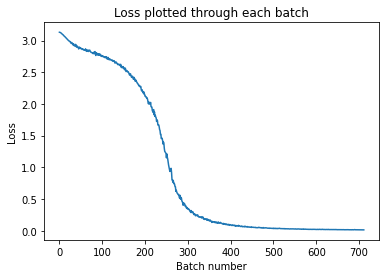

In [4]:
# Plotting the loss through the epochs
plt.plot(loss_list)
#plt.scatter(range(len(loss_list)), loss_list)
plt.title("Loss plotted through each batch")
plt.ylabel("Loss")
plt.xlabel("Batch number")
#plt.yscale("log")
#plt.xscale("log")
plt.savefig("loss_log.png")

In [5]:
# Predicting
accuracies = []
with torch.no_grad():
    # Loading saved model from file
    model.load_state_dict(torch.load("model.pth"))
    #model.eval()

    # Initalising data generator
    #dataset = Dataset(small_file, max_seq_len, acids=acids)
    #base_generator = data.DataLoader(dataset, batch_size=32, shuffle=True, num_workers=8)

    correct = 0
    
    # For loops is easiest way to get an element from
    # the generator even though we only loop once
    for i, (batch, labels, valid_elems) in enumerate(base_generator):
        test = batch
        batch = batch.to(processor)
        labels = labels.to(processor)

        # Transposing from (batch x seq x feature_size) to (seq x batch x feature_size)
        batch = batch.transpose(0,1)
        #labels = torch.transpose(labels, 0, 1)

        batch = rnn.pack_padded_sequence(batch, valid_elems, enforce_sorted=False)

        out, hidden = model(batch)

        out = out.transpose(0,1)

        print(out.size())
        print(valid_elems.size())
        for j in range(batch_size):
            preds = torch.argmax(out[j], dim=1)[:valid_elems[j]]
            actual = labels[j][:valid_elems[j]]
            truths = [1 if pred == truth else 0 for pred, truth in zip(preds, actual)]
            correct += sum(truths)
        accuracy = correct/(torch.sum(valid_elems).item())
        break
    
print("Test Accuracy: {0:.3f}%".format(accuracy*100))
print(labels.size())

#print(torch.argmax(out[0], dim=1))
#print(torch.max(out[0,:10], dim=1))
#print(torch.argmax(out[0,:10], dim=1))
#print(out[0,:10])

print("\nPredictions")
print_seq(out[0].view(1,out.size()[1], out.size()[2]), valid_elems, acids)
print("\nInput")
print_seq(test[0].view(1,test.size()[1], test.size()[2]), valid_elems, acids)

print_labels = ""
for elem in labels[0][:valid_elems[0]]:
    print_labels += acids[elem]

print("\nLabels")
print(print_labels)

#print_seq(out, valid_elems)


torch.Size([32, 500, 23])
torch.Size([32])


Test Accuracy: 99.969%
torch.Size([32, 500])

Predictions
Sequence 0
MKKLLLTLAMVPAVLFSPTAWGDATDDLLGRLQTLESMKGGFEQVVLDQSGTHMQEALGKFQVARGNRFYWLTETPYEQMAASDGTTVWVYDKDLEQVVVRPLSQDLGQTPALLFGGKPADVAKAFTISERDNRGAEVTYRLTPKGQDPLFDQLDVTFKGGQPASMRLQDALGQQTVIDFIGLTLNDGIDSSLFHFDPPEGTDVIQQQQ

Input
Sequence 0
MKKLLLTLAMVPAVLFSPTAWGDATDDLLGRLQTLESMKGGFEQVVLDQSGTHMQEALGKFQVARGNRFYWLTETPYEQMAASDGTTVWVYDKDLEQVVVRPLSQDLGQTPALLFGGKPADVAKAFTISERDNRGAEVTYRLTPKGQDPLFDQLDVTFKGGQPASMRLQDALGQQTVIDFIGLTLNDGIDSSLFHFDPPEGTDVIQQQQ

Labels
MKKLLLTLAMVPAVLFSPTAWGDATDDLLGRLQTLESMKGGFEQVVLDQSGTHMQEALGKFQVARGNRFYWLTETPYEQMAASDGTTVWVYDKDLEQVVVRPLSQDLGQTPALLFGGKPADVAKAFTISERDNRGAEVTYRLTPKGQDPLFDQLDVTFKGGQPASMRLQDALGQQTVIDFIGLTLNDGIDSSLFHFDPPEGTDVIQQQQ
